In [1]:
##Loading modules. 

# General modules
from __future__ import division, print_function
# %matplotlib inline
import os
import sys
import time
import datetime
import shutil

In [2]:
# Specific science modules
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm


In [3]:
# Specific qubic modules
import pysm3
import qubic
from qubicpack.utilities import Qubic_DataDir
from pysimulators import FitsArray


In [4]:
from qubic import SpectroImLib as si
from pysm3 import models
from qubic import QubicSkySim as qss


In [5]:
# Repository for dictionary
global_dir = Qubic_DataDir(datafile='instrument.py', datadir='../')
dictfilename = global_dir + 'dicts/pipeline_demo.dict'

In [6]:
# Read dictionary chosen
d = qubic.qubicdict.qubicDict()
d.read_from_file(dictfilename)

In [7]:
# Set nf_sub to 1 to be in the monofreq case
d['nf_sub'] = 1

In [8]:
# No spectroimaging
d['nf_recon'] = 1

In [9]:
# Center of the patch observed in galactic coordinates
center = qubic.equ2gal(d['RA_center'], d['DEC_center'])
print(center)
d['effective_duration'] = 4

# Adjust some parameters in the dictionary
d['npointings'] = 3000
d['tol'] = 1e-5
d['filter_nu'] = 220e9
d['photon_noise'] = False
d['noiseless'] = False


(array(316.44761929), array(-58.75808063))


In [10]:
print(d['filter_nu'])
print(d['detector_nep'])
print(d['photon_noise'])
print(d['config'])
print(d['effective_duration'])

220000000000.0
4.7e-17
False
FI
4


In [11]:
# decide whether to use fits file synth beam
d['use_synthbeam_fits_file']=True


In [12]:
# Make a sky using PYSM
### Pick one of these:
seed = 42
sky_config = {'CMB': 'c1'} 
# sky_config = {'cmb': 42}                ### CMB Only
#sky_config = {'cmb': seed, 'dust':'d1'}   ### CMB + Dust

In [13]:
### Generate the maps at each sub-frequency
Qubic_sky = qss.Qubic_sky(sky_config, d)
x0 = Qubic_sky.get_simple_sky_map()

In [14]:
print('sky shape: ', x0.shape)

sky shape:  (1, 786432, 3)


In [15]:
# Look at the input sky maps using Healpy
istokes = 0 # Stokes parameter (I, Q, U)
rr = 9 # Resolution in arcmin

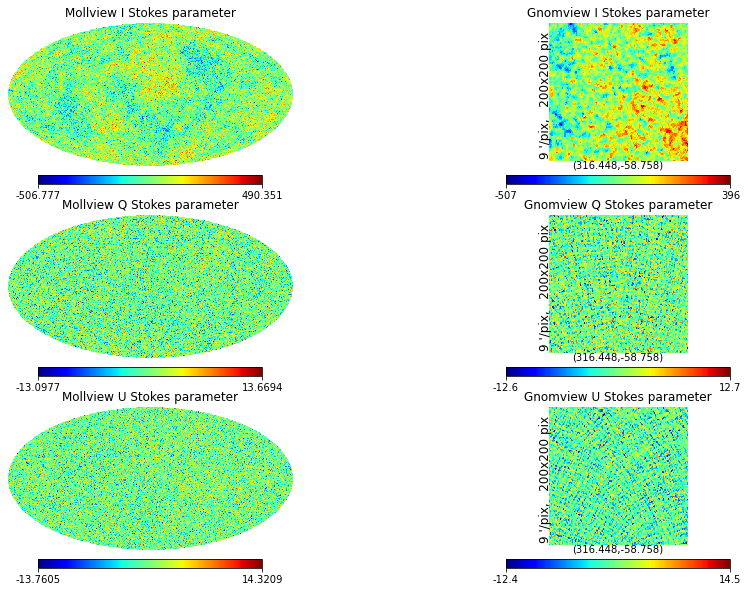

In [16]:
plt.figure(figsize=(13,8))
for istk in range(3):
    plt.subplots_adjust(wspace=0.9)
    hp.mollview(x0[0, :,istk], cmap='jet', sub = (3,2,2*istk+1), 
        title = 'Mollview {0} Stokes parameter'.format(d['kind'][istk]))
    hp.gnomview(x0[0, :,istk], cmap ='jet', sub = (3,2,2*istk+2), rot=center, reso=rr, 
        title = 'Gnomview {0} Stokes parameter'.format(d['kind'][istk]))


In [17]:
# Pointing strategy
p = qubic.get_pointing(d)
print('=== Pointing DONE! ===')

You asked 3000 pointings with repeat strategy so I will provide 1000 pointings repeated 3 times.
=== Pointing DONE! ===


In [18]:
# Model of the scene at the time of observation
s = qubic.QubicScene(d)

you are here


In [19]:
# Create a monofrequency Instrument.
q = qubic.QubicInstrument(d)

In [20]:
# Create an acquisition operator which combines all relevant information
#scene, instrument configuration and pointing strategy. 
a = qubic.QubicAcquisition(q, p, s, d)

In [21]:
# Monofreq TOD making
TOD, maps_convolved = a.get_observation(x0[0], noiseless=d['noiseless'])#, convolution = True)

220
2
you are here
Info apcmcqubic.in2p3.fr: Allocating (2976000,9) elements = 408.69140625 MiB in FSRRotation3dMatrix.__init__.


/Users/mwright/.local/lib/python3.9/site-packages/qubic/jchinstrument.py:959: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  thetas = thetas[index]
/Users/mwright/.local/lib/python3.9/site-packages/qubic/jchinstrument.py:960: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  phis = phis[index]
/Users/mwright/.local/lib/python3.9/site-packages/qubic/jchinstrument.py:961: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an

In [22]:
print('TOD shape: ', TOD.shape)
print('maps conv shape: ', maps_convolved.shape)

TOD shape:  (992, 3000)
maps conv shape:  (786432, 3)


--------- TOD with shape (#detectors, #pointings) : (992, 3000) 


Text(0.5, 1.0, 'FI - 220GHz - Noiseless=False CMB - STD = 4.918e-18 W')

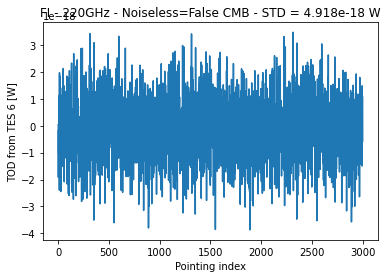

In [23]:
# Look at TOD for one TES
print('--------- TOD with shape (#detectors, #pointings) : {} '.format(np.shape(TOD)))

tes = 6
plt.plot(TOD[tes, :], label='TES {}'.format(tes))
plt.xlabel('Pointing index')
plt.ylabel(f'TOD from TES {tes} [W]')
plt.title('FI - 220GHz - Noiseless={} CMB - STD = {:.4} W'.format( d['noiseless'], np.std(TOD)))

220
2
you are here
Info apcmcqubic.in2p3.fr: Allocating (2976000,9) elements = 408.69140625 MiB in FSRRotation3dMatrix.__init__.


/Users/mwright/.local/lib/python3.9/site-packages/qubic/jchinstrument.py:959: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  thetas = thetas[index]
/Users/mwright/.local/lib/python3.9/site-packages/qubic/jchinstrument.py:960: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  phis = phis[index]
/Users/mwright/.local/lib/python3.9/site-packages/qubic/jchinstrument.py:961: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an

(786432,)


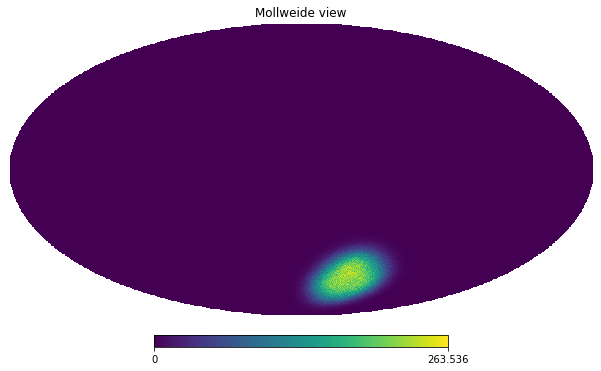

In [24]:
# Get coverage map
# i.e. how many times were seen each pixel of the sky (not trivial because of the synthetic beam)
cov = a.get_coverage()

print(cov.shape)
hp.mollview(cov)

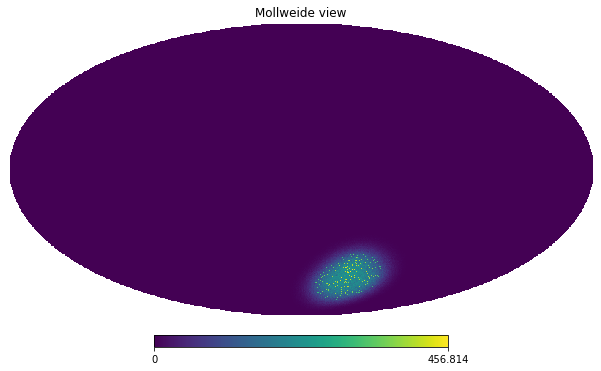

In [25]:
# Check the pointing and the coverage coincide
theta = p.galactic[:, 0]
phi = p.galactic[:, 1]
nside = d['nside']

pix = hp.ang2pix(nside, theta, phi, lonlat=True)
ptg_map = np.zeros(12 * nside**2)
ptg_map[pix] = 200
hp.mollview(ptg_map + cov)

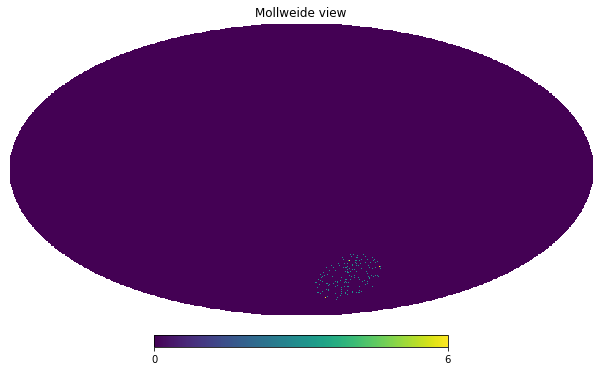

In [26]:
hitmap = a.get_hitmap(d['nside'])
hp.mollview(hitmap)

In [27]:
# From TOD reconstruct sky maps.
maps_recon, nit, error = a.tod2map(TOD, d, cov=cov)

print('The shape of the reconstructed maps is (#pixels, #stokes) :', maps_recon.shape)
print('{} iterations were needed to get an error of {}'.format(nit, error))

220
2
you are here
Info apcmcqubic.in2p3.fr: Allocating (2976000,9) elements = 408.69140625 MiB in FSRRotation3dMatrix.__init__.
In acquisition.py: self.forced_sigma=None
and self.sigma is:3.323401871576773e-17
Using theoretical TES noises
diagonal case
(2976000, 2976000)
905387052965142904678190040481792I


/Users/mwright/.local/lib/python3.9/site-packages/pyoperators-0.13.dev1-py3.9-macosx-10.9-x86_64.egg/pyoperators/nonlinear.py:322: RuntimeWarning: invalid value encountered in reciprocal
  np.reciprocal(input, output)
/Users/mwright/.local/lib/python3.9/site-packages/qubic/acquisition.py:480: RuntimeWarning: divide by zero encountered in true_divide
  cov_inv = 1 / cov


   1: 0.3489755391218911
   2: 0.20872266577950863
   3: 0.09421499404598713
   4: 0.059962829700619516
   5: 0.031475707848707034
   6: 0.020825334275876496
   7: 0.01925637357786284
   8: 0.01601586505260816
   9: 0.011360200050656038
  10: 0.008329361235237767
  11: 0.00682582157658447
  12: 0.004932610942873337
  13: 0.003223888775109173
  14: 0.0023103975350833956
  15: 0.0017637367356915135
  16: 0.001364767239825092
  17: 0.0010799705365618808
  18: 0.0008674930124269189
  19: 0.000687587090764809
  20: 0.0005726501776617365
  21: 0.0004851695434984886
  22: 0.00046329501297753535
  23: 0.0008598453870954398
  24: 0.0003911224143042299
  25: 0.00034170242437977805
  26: 0.00031061715422256415
  27: 0.0002874644133782529
  28: 0.000262520688884424
  29: 0.0002815223252022542
  30: 0.00038301302618983966
  31: 0.0002389639151934432
  32: 0.0002291737492678681
  33: 0.0002195353572206785
  34: 0.00032591179961346834
  35: 0.00022492405037031332
  36: 0.0001865962966461282
  37: 0.0

In [28]:
# Compare with the convolved maps
diff = maps_recon - maps_convolved
print(diff.shape)
print(maps_recon.shape)

(786432, 3)
(786432, 3)


In [29]:
# Keeping only the sky region which has been significantly observed
# Pixels not seen enough are replaced by UNSEEN value
maxcov = np.max(cov)
unseen = cov < maxcov * 0.15

maps_convolved[unseen, :] = hp.UNSEEN
maps_recon[unseen, :] = hp.UNSEEN
diff[unseen, :] = hp.UNSEEN

60.1851507900177 119.8148492099823 -29.814849209982302 29.814849209982302
60.1851507900177 119.8148492099823 -29.814849209982302 29.814849209982302
60.1851507900177 119.8148492099823 -29.814849209982302 29.814849209982302
60.1851507900177 119.8148492099823 -29.814849209982302 29.814849209982302
60.1851507900177 119.8148492099823 -29.814849209982302 29.814849209982302
60.1851507900177 119.8148492099823 -29.814849209982302 29.814849209982302
60.1851507900177 119.8148492099823 -29.814849209982302 29.814849209982302
60.1851507900177 119.8148492099823 -29.814849209982302 29.814849209982302
60.1851507900177 119.8148492099823 -29.814849209982302 29.814849209982302


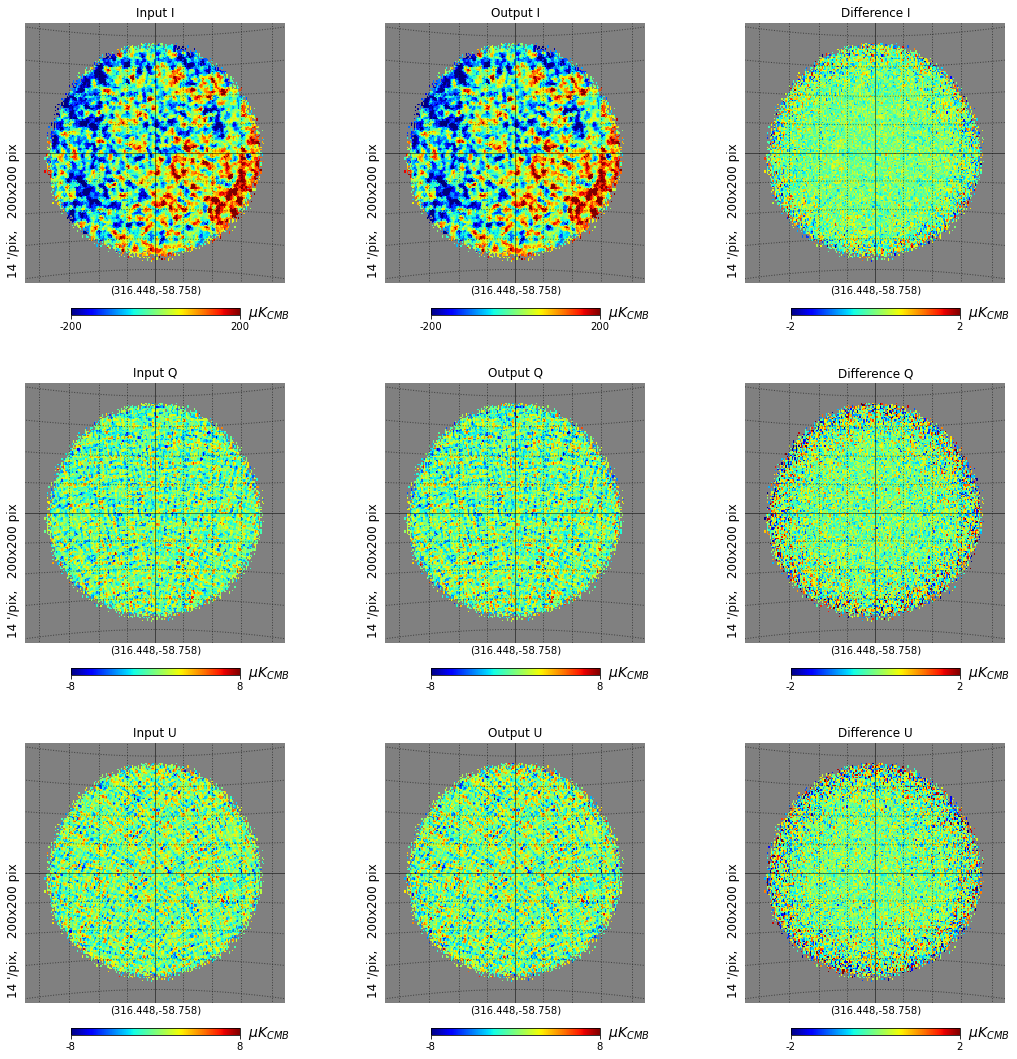

In [30]:
rr = 14 # Resolution in arcmin
stokes = ['I', 'Q', 'U']
plt.figure(figsize=(15, 15))
for istokes in range(3):
    if istokes == 0:
        min = -200
        max = 200
    else:
        min = -8
        max = 8
    hp.gnomview(maps_convolved[:, istokes], cmap='jet', rot=center, sub=(3,3,3*istokes+1), reso=rr,
                title='Input ' + stokes[istokes], unit='$\mu K_{CMB}$', format='%g',  min=min, max=max)
    hp.gnomview(maps_recon[:, istokes], cmap='jet',rot=center, sub=(3,3,3*istokes+2), reso=rr,
                title='Output ' + stokes[istokes], unit='$\mu K_{CMB}$', min=min, max=max)
    hp.gnomview(diff[:, istokes], cmap='jet',rot=center, sub=(3,3,3*istokes+3), reso=rr,
                title='Difference ' + stokes[istokes], unit='$\mu K_{CMB}$', min=-2, max=2)
hp.graticule(dpar = 5, dmer = 5, verbose = False, alpha = 0.5)
plt.savefig('comparison_map.pdf')

In [31]:
# now run it all again with just the analytic calculation
# decide whether to use fits file synth beam
d['use_synthbeam_fits_file']=False
# Pointing strategy
p = qubic.get_pointing(d)
print('=== Pointing DONE! ===')
# Model of the scene at the time of observation
s = qubic.QubicScene(d)
# Create a monofrequency Instrument.
q = qubic.QubicInstrument(d)
# Create an acquisition operator which combines all relevant information
#scene, instrument configuration and pointing strategy. 
a = qubic.QubicAcquisition(q, p, s, d)

You asked 3000 pointings with repeat strategy so I will provide 1000 pointings repeated 3 times.
=== Pointing DONE! ===
you are here


220
2
Normal
Info apcmcqubic.in2p3.fr: Allocating (2976000,9) elements = 408.69140625 MiB in FSRRotation3dMatrix.__init__.


/Users/mwright/.local/lib/python3.9/site-packages/qubic/jchinstrument.py:1029: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  theta = theta[index]
/Users/mwright/.local/lib/python3.9/site-packages/qubic/jchinstrument.py:1030: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  phi = phi[index]
/Users/mwright/.local/lib/python3.9/site-packages/qubic/jchinstrument.py:1031: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an 

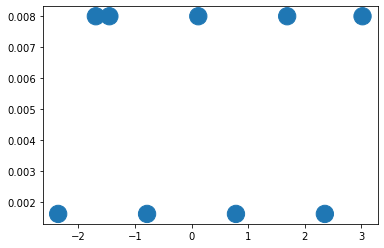

In [32]:
# Monofreq TOD making
TOD2, maps_convolved2 = a.get_observation(x0[0], noiseless=d['noiseless'])#, convolution = True)

220
2
Normal
Info apcmcqubic.in2p3.fr: Allocating (2976000,9) elements = 408.69140625 MiB in FSRRotation3dMatrix.__init__.
In acquisition.py: self.forced_sigma=None
and self.sigma is:3.323401871576773e-17
Using theoretical TES noises
diagonal case
(2976000, 2976000)
905387052965142904678190040481792I


/Users/mwright/.local/lib/python3.9/site-packages/pyoperators-0.13.dev1-py3.9-macosx-10.9-x86_64.egg/pyoperators/nonlinear.py:322: RuntimeWarning: invalid value encountered in reciprocal
  np.reciprocal(input, output)
/Users/mwright/.local/lib/python3.9/site-packages/qubic/acquisition.py:480: RuntimeWarning: divide by zero encountered in true_divide
  cov_inv = 1 / cov


   1: 0.3489755391218911
   2: 0.20872266577950863
   3: 0.09421499404598715
   4: 0.05996282970061953
   5: 0.031475707848707055
   6: 0.020825334275876614
   7: 0.019256373577863535
   8: 0.01601586505260769
   9: 0.011360200050654141
  10: 0.008329361235234584
  11: 0.006825821576597591
  12: 0.004932610942933756
  13: 0.0032238887752488944
  14: 0.002310397535407423
  15: 0.0017637367364452218
  16: 0.0013647672409834754
  17: 0.0010799705085800218
  18: 0.0008674930624182266
  19: 0.0006875850337543244
  20: 0.0005726391604800762
  21: 0.00048481098176830485
  22: 0.0004330991987692642
  23: 0.0007174813983618253
  24: 0.0004520499633453079
  25: 0.0003423061463921195
  26: 0.0003106229164896936
  27: 0.00028746532964782264
  28: 0.00026232051650136807
  29: 0.00027153142476583165
  30: 0.0003996729544534947
  31: 0.00024094164050931222
  32: 0.00022916690761165794
  33: 0.00021754010507620735
  34: 0.00030209605694355384
  35: 0.0002378504634620027
  36: 0.00018685623706218057
  

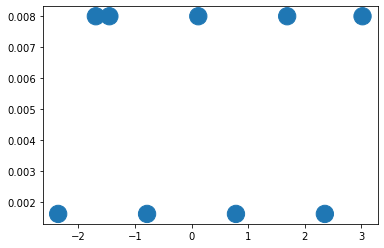

In [33]:
# From TOD reconstruct sky maps.
maps_recon2, nit2, error2 = a.tod2map(TOD, d, cov=cov)

print('The shape of the reconstructed maps is (#pixels, #stokes) :', maps_recon2.shape)
print('{} iterations were needed to get an error of {}'.format(nit2, error2))

In [34]:
# Keeping only the sky region which has been significantly observed
# Pixels not seen enough are replaced by UNSEEN value
maxcov = np.max(cov)
unseen = cov < maxcov * 0.15

maps_convolved2[unseen, :] = hp.UNSEEN

In [35]:
diff2 = maps_convolved2 - maps_convolved
diff2[unseen, :] = hp.UNSEEN

60.1851507900177 119.8148492099823 -29.814849209982302 29.814849209982302
60.1851507900177 119.8148492099823 -29.814849209982302 29.814849209982302
60.1851507900177 119.8148492099823 -29.814849209982302 29.814849209982302
60.1851507900177 119.8148492099823 -29.814849209982302 29.814849209982302
60.1851507900177 119.8148492099823 -29.814849209982302 29.814849209982302
60.1851507900177 119.8148492099823 -29.814849209982302 29.814849209982302
60.1851507900177 119.8148492099823 -29.814849209982302 29.814849209982302
60.1851507900177 119.8148492099823 -29.814849209982302 29.814849209982302
60.1851507900177 119.8148492099823 -29.814849209982302 29.814849209982302


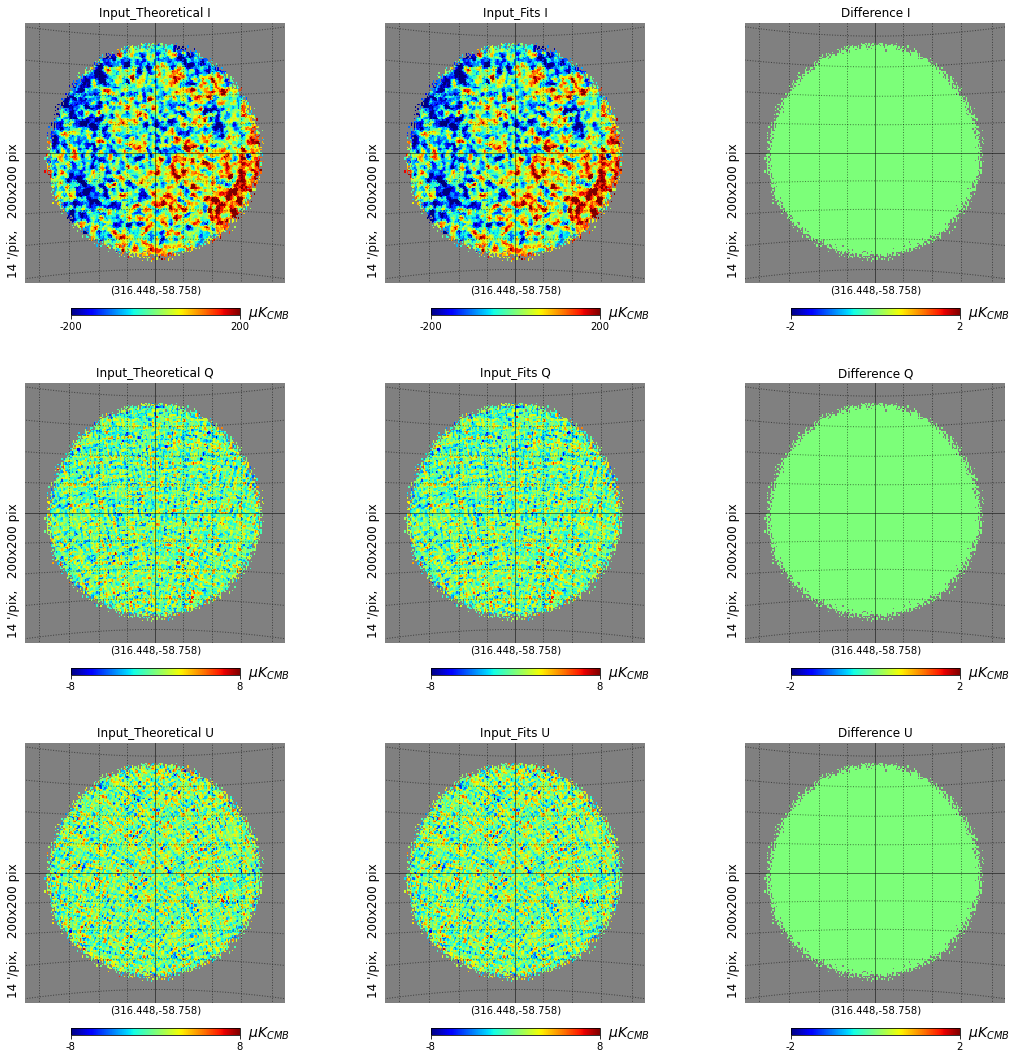

In [36]:
rr = 14 # Resolution in arcmin
stokes = ['I', 'Q', 'U']
plt.figure(figsize=(15, 15))
for istokes in range(3):
    if istokes == 0:
        min = -200
        max = 200
    else:
        min = -8
        max = 8
    hp.gnomview(maps_convolved2[:, istokes], cmap='jet', rot=center, sub=(3,3,3*istokes+1), reso=rr,
                title='Input_Theoretical ' + stokes[istokes], unit='$\mu K_{CMB}$', format='%g',  min=min, max=max)
    hp.gnomview(maps_convolved[:, istokes], cmap='jet',rot=center, sub=(3,3,3*istokes+2), reso=rr,
                title='Input_Fits ' + stokes[istokes], unit='$\mu K_{CMB}$', min=min, max=max)
    hp.gnomview(diff2[:, istokes], cmap='jet',rot=center, sub=(3,3,3*istokes+3), reso=rr,
                title='Difference ' + stokes[istokes], unit='$\mu K_{CMB}$', min=-2, max=2)
hp.graticule(dpar = 5, dmer = 5, verbose = False, alpha = 0.5)
plt.savefig('comparison_map.pdf')